In [24]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


Let us consider the function:

$$f : \mathbb{R}^2 \rightarrow \mathbb{R}; \qquad x \rightarrow 2\sin (x_1) - 3\cos (x_2)$$

restricted to the box range:

\begin{equation}
x_1 \in [-2, 2], x_2 \in [-2, 2].
\end{equation}


We have a training and a test datasets with 500 samples each, uniformly sampled within the domain. Samples are corrupted with an additive Gaussian noise with standard deviation $\sigma_e = 0.1$

We reconstruct the function using a MLP characterized by
* 2 input channels and 1 output channel - not a choice, this is the structure of $f(x)$: 
* 2 hidden layers
* 32 neurons in the first layer, 16 neurons in the second layer
* $\tanh$ activation function 

In [25]:
# Constants

n_x = 2 # number of inputs
n_y = 1 # number of outputs
a = -2.0 # lower bound x_1/x_2
b = 2.0 # upper bound x_1/x_2
n_samples = 500 # number of samples in the training/test datasets
sigma_e = 0.1 # standard deviation of the noise
grid_points = 100 # number of points in the grid for the plot

In [26]:
# Function definition

def f(x):
    return 2*torch.sin(x[..., 0])  - 3*torch.cos(x[..., 1]) # ellipses used to handle an optional "batch" dimension
# f(torch.tensor([0.2, 0.4])), 2*np.sin(0.2) - 3*np.cos(0.4) # test

In [27]:
# Generate synthetic data

x1_train = a + torch.rand(n_samples)*(b - a)
x2_train = a + torch.rand(n_samples)*(b - a)
X_train = torch.stack([x1_train, x2_train], dim=-1)

y_train = f(X_train) + sigma_e * torch.randn(n_samples)
y_train = y_train.view(-1, 1)
X_train.shape, y_train.shape 

(torch.Size([500, 2]), torch.Size([500, 1]))

In [28]:
x1_test = a + torch.rand(n_samples)*(b - a)
x2_test = a + torch.rand(n_samples)*(b - a)
X_test = torch.stack([x1_test, x2_test], dim=-1)

y_test = f(X_test) + sigma_e * torch.randn(n_samples)
y_test = y_test.view(-1, 1)
X_test.shape, y_test.shape 

(torch.Size([500, 2]), torch.Size([500, 1]))

In [29]:
# Visualize the true function - impossible in real-world problems and in higher dimensions!

x1_grid = np.linspace(a, b, grid_points)
x2_grid = np.linspace(a, b, grid_points)
X1_grid, X2_grid = np.meshgrid(x1_grid, x2_grid)
X_grid = torch.tensor(np.c_[X1_grid.ravel(), X2_grid.ravel()], dtype=torch.float32)
y_grid = f(X_grid)
X_grid.shape, X1_grid.shape, X2_grid.shape, y_grid.shape

(torch.Size([10000, 2]), (100, 100), (100, 100), torch.Size([10000]))

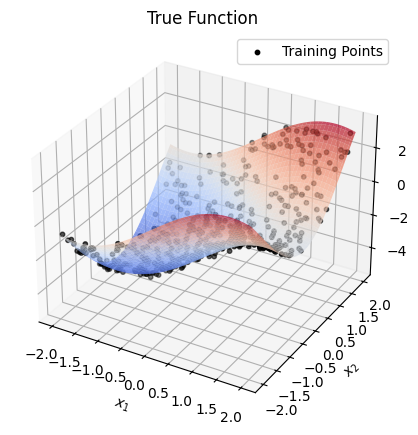

In [30]:
# 3D Plot of True Function
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X1_grid, X2_grid, y_grid.view(100, 100).numpy(), cmap='coolwarm', alpha=0.7)#, edgecolor='none')
ax1.set_title("True Function")
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
ax1.scatter(X_train[:, 0].numpy(), X_train[:, 1].numpy(), y_train[:, 0].numpy(), color='k', s=10, label='Training Points')
ax1.legend()
ax1.set_zlabel("$y$")
plt.show()

### Define a feed-forward neural network

In [31]:
hidden_size_1 = 32
hidden_size_2 = 16

In [32]:
class FeedForwardNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(n_x, hidden_size_1) 
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(hidden_size_2, n_y)
        


    def forward(self, x):
        x = self.act1(self.fc1(x)) # 32
        x = self.act2(self.fc2(x)) # 16
        x = self.fc3(x) # 1
        return x

model = FeedForwardNN()


### Train the neural network on the training dataset

In [33]:
epochs = 5000
lr = 1e-3
batch_size = 256

# Dataset, DataLoader Loss, and Optimizer

train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
criterion = nn.MSELoss() # we may also define the loss manually in the training loop
optimizer = optim.Adam(model.parameters(), lr=lr)

LOSS = []

# Optimization loop
for epoch in range(epochs):
    loss_epoch = 0.0 # just for diagnostic, we track the average loss in the training epoch

    for batch_x, batch_y in train_dl:
        optimizer.zero_grad()
        batch_y_pred = model(batch_x)
        loss = criterion(batch_y_pred, batch_y)
        # loss = torch.mean((batch_y_pred - batch_y)**2) 
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        
    loss_epoch /= len(train_dl) # divide by number of batches per epoch to get an average
    LOSS.append(loss_epoch)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss_epoch:.4f}", end="\r") # diagnostic output (once per epoch here)

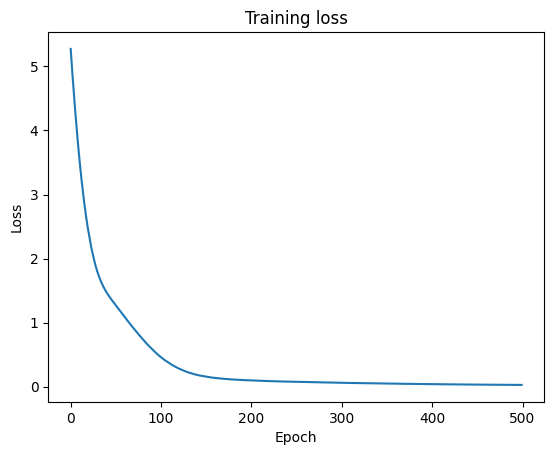

In [34]:
# Plots

plt.figure()
plt.plot(LOSS)
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss');

### Evaluate model performance on the test dataset

In [42]:
# Generate model prediction on the test set (optionally also on the training set)
with torch.no_grad():
    y_test_hat = model(X_test) # model accepts normalized x

err_test_hat = (y_test_hat - y_test)
rsme = torch.sqrt(torch.mean(err_hat**2))
print(f"RSME: {rsme:.3f}") # note: sigma_e = 0.1, so RSME can't be smaller than that

y_test_hat.shape



RSME: 0.194


torch.Size([500, 1])

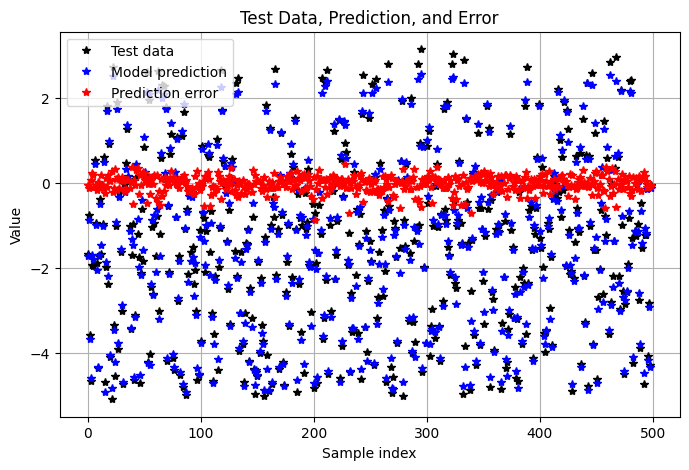

In [43]:
# Assume x_test is 1D (or just use index if x_test is 2D)
sample_nb = range(len(y_test))  # Or use x_test.flatten() if available

plt.figure(figsize=(8, 5))

plt.plot(sample_nb, y_test, 'k*', label="Test data")
plt.plot(sample_nb, y_test_hat, 'b*', label="Model prediction")
plt.plot(sample_nb, err_test_hat, 'r*', label="Prediction error")

plt.xlabel('Sample index')
plt.ylabel('Value')
plt.legend()
plt.title('Test Data, Prediction, and Error')
plt.grid(True)
plt.show()